# Results: Late period

This notebook displays BML results for the early period.

In [1]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [3]:
library(brms)
library(dplyr)
library(data.table)

library(tidyverse)
library(ggridges)
options(warn = -1)

## Model

Model expressed in lme4 format:

<center> Y $\sim$ 1 + cond + state + trait + (1 + cond | SUB) + (1 + cond + state + trait | ROI) </center>

Full model therefore (in the notation McElreath 2020):  

$$Y_{s,r} \sim Student(\nu,\mu_{s,r},\sigma^{2}_{s,r})$$  
$$\mu_{s,r} = \alpha + \alpha_{SUB} + \alpha_{ROI} + (\beta_{cond} +\beta_{SUB_{cond}}+ \beta_{ROI_{cond}})*cond + (\beta_{state} + \beta_{ROI_{state}})*state + (\beta_{trait} + \beta_{ROI_{trait}})*trait + \epsilon $$


Where,  
$\mu_{s,r}$: mean ROI response in the given subject for a particular phase and block type.     
_cond_: Threat (0.5) vs. Safe (-0.5)  
_state_: subject's state score  
_trait_: subject's trait score  

## Priors

$\alpha \sim Student(3,0,10)$ [population effect]  
$\alpha_{SUB} \sim Student(\nu_{SUB},0,\sigma_{SUB})$ [Subject effect]    
$\alpha_{ROI} \sim Student(\nu_{ROI},0,\sigma_{ROI})$ [ROI effect]  

$\beta_{cond} \sim Student(3,0,10)$ [population effect: cond]  
$\beta_{state} \sim Student(3,0,10)$ [population effect: state]    
$\beta_{trait} \sim Student(3,0,10)$ [population effect: trait]  

$\begin{bmatrix}
  \alpha_{ROI} \\
  \beta_{ROI_{cond}} \\
  \beta_{ROI_{state}} \\
  \beta_{ROI_{trait}}
\end{bmatrix} \sim MVNormal(\begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \end{bmatrix},S)$

$ S = \begin{bmatrix} \sigma_{\alpha_{ROI}} & & & \\ & \sigma_{\beta_{ROI_{cond}}} & & \\ & & \sigma_{\beta_{ROI_{state}}} & \\ & & & \sigma_{\beta_{ROI_{trait}}} \end{bmatrix} R \begin{bmatrix} \sigma_{\alpha_{ROI}} & & & \\ & \sigma_{\beta_{ROI_{cond}}} & & \\ & & \sigma_{\beta_{ROI_{state}}} & \\ & & & \sigma_{\beta_{ROI_{trait}}} \end{bmatrix}$

$\begin{bmatrix}
  \alpha_{SUB} \\
  \beta_{SUB_{cond}}
\end{bmatrix} \sim MVNormal(\begin{bmatrix} 0 \\ 0 \end{bmatrix},S)$

$ S = \begin{bmatrix} \sigma_{\alpha_{SUB}} & \\ & \sigma_{\beta_{SUB_{cond}}} \end{bmatrix} R \begin{bmatrix} \sigma_{\alpha_{SUB}} & \\ & \sigma_{\beta_{SUB_{cond}}} \end{bmatrix}$


$\sigma_{SUB} \sim HalfStudent(3,0,10)$ [prior stddev for Subject effect]    
$\sigma_{ROI} \sim HalfStudent(3,0,10)$ [prior stddev for ROI effect]    
$\nu_{SUB} \sim \Gamma(3.325,0.1)$ [Subject effect hyperprior]    
$\nu_{ROI} \sim \Gamma(3.325,0.1)$ [ROI effect hyperprior]  

$\sigma_{\alpha} \sim HalfStudent(3,0,10)$ [prior stddev among intercepts]  
$\sigma_{\beta} \sim HalfStudent(3,0,10)$ [prior stddev among slopes]

$R \sim LKJcorr(2)$ [prior of correlation matix]


In [4]:
# Load the BML output image
load('results/late.RData')
outDir = 'results/late_'
summary_file = paste0(outDir,'summary.txt')

In [5]:
print('Following are the first few rows of thet dataset used in BML')
head(dataTable)

[1] "Following are the first few rows of thet dataset used in BML"


,Subj,ROI,beta,se,cond,TRAIT,STATE
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,MAX101,L ACC,-0.005894,0.03244996,-0.5,-1.164152,-1.011495
2,MAX101,L BLBM Amygdala,0.391430,0.09052624,-0.5,-1.164152,-1.011495
3,MAX101,L BST,-0.227433,0.11572813,-0.5,-1.164152,-1.011495
4,MAX101,L CeMe Amygdala,-0.012446,0.09642614,-0.5,-1.164152,-1.011495
5,MAX101,L Crus II,-0.059655,0.02801785,-0.5,-1.164152,-1.011495
6,MAX101,L Hippocampus body,-0.057956,0.04732864,-0.5,-1.164152,-1.011495


In [6]:
EOIq <- unlist(lapply(strsplit(mod,'\\+')[[1]],trimws))
if(!('Intercept' %in% EOIq)) EOIq <- c('Intercept', EOIq)
EOIq <- EOIq[!grepl('1', EOIq)]

print('Fixed effect model terms:')
print(EOIq)

[1] "Fixed effect model terms:"
[1] "Intercept" "cond"      "STATE"     "TRAIT"    


In [7]:
# Print the BML output summary
cat('====================================== BML output Summary ======================================',
    file = summary_file, sep = '\n')
cat(capture.output(summary(fm)), file = summary_file, sep = '\n')

In [8]:
# Extract posteriors for fixed (aa) and random effects (bb)
aa <- fixef(fm, summary = FALSE)/SCALE # Population-Level Estimates
bb <- lapply(ranef(fm, summary = FALSE), `/`, SCALE) # Extract Group-Level (or random-effect)

# Sum the fixed and random effect (only ROI) posterior. Following function does this.
# The function adds the "the poaterior of the global intercept (or slope) with the 
# intercept (or slope) posterior of each roi. bb[['ROI']][,,tm] is a matrix with 
# columns containing posteriors for every ROI
# aa[,tm] is a single column posterior for the global intercept/slope.
# intercept or slope is defined by tm, where tm is the index of the model term.
psROI <- function(aa, bb, tm) {
  ps <- apply(bb[['ROI']][,,tm], 2, '+', aa[,tm])
  return(ps)
}

#################################### Following functions are used for summarizing BML and GLM outputs in a table from ############################
# function to compute P+
cnt <- function(x, ns) return(sum(x>0)/ns)

# function that creates a BML summary table for ROI posteriors (mean, std, and quartiles),
# nd - number of digits to output
sumROI <- function(R0, ns, nd) {
  hubs <- data.frame(cbind(apply(R0, 2, mean), apply(R0, 2, sd), apply(R0, 2, cnt, ns), t(apply(R0, 2, quantile, 
      probs=c(0.025, 0.05, 0.5, 0.95, 0.975)))))
  names(hubs) <- c('mean', 'SD', 'P+', '2.5%', '5%', '50%', '95%', '97.5%')
  return(round(hubs,nd))
}

# function that run conventional glm on each ROI individually
sumGLM <- function(ll, tm, nR, DF, nd) {
   th <- qt(c(0.025, 0.05, 0.5, 0.95, 0.975), DF)
   rr <- matrix(0, nrow = nR, ncol = 8, dimnames=list(levels(dataTable$ROI), c('mean', 'SD', '2-sided-p', '2.5%', '5%', '50%', '95%', '97.5%')))
   rownames(rr) <- levels(dataTable$ROI)
   if(tm == 'Intercept') tm <- '(Intercept)'
   for(ii in 1:nR) {
     u1 <- ll[[ii]]$coefficients[tm,1] # mean
     u2 <- ll[[ii]]$coefficients[tm,2] # sd
     u3 <- ll[[ii]]$coefficients[tm,4] # 2-sided p
     rr[ii,] <- round(c(u1, u2, u3, u1+u2*th),nd)
   } 
   return(rr)
}

In [9]:
# Following print BML and GLM result summary for each ROI
for (ii in 1:length(EOIq)){
    #cat('\n',paste0(outDir,'summary.txt'), sep = '\n', append=TRUE)
    cat(sprintf('========= Summary of region effects for %s (RBA results) =========', EOIq[ii]), 
        file = summary_file, sep = '\n', append=TRUE)
    ps0 <- psROI(aa, bb, EOIq[ii])
    gg_brm <- sumROI(ps0, ns, nfigs)
    write.table(gg_brm,file = paste0(outDir,EOIq[ii],'.txt'),sep = ',')
    #gg_brm$ROI <- factor(rownames(gg_brm))
    cat(capture.output(gg_brm), file = summary_file, sep = '\n', append=TRUE)

    cat(sprintf('==================================================================================================================='), 
        file = summary_file, sep='\n', append=TRUE)
    cat(sprintf('========= Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =========', EOIq[ii]),
        file = summary_file,sep = '\n', append=TRUE)
    mm <- list()
    GLM <- as.formula(paste('beta ~ ',mod))
    if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
    for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
    nn <- lapply(mm, summary)
    ll <- lapply(nn, `[`, 'coefficients')
    gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
    gg_glm = as.data.frame(gg_glm)
    cat(capture.output(gg_glm), file = summary_file, sep = '\n', append=TRUE)
    cat('\n',file = summary_file, sep = '\n', append=TRUE)
}

In [10]:
# Function to create ridge plots 
plotPDP <- function(posteriors) {
    rm(list=ls())
    ## import BML posterior table
    posteriors <- as_tibble(posteriors)
    df.long <- posteriors %>% reshape2::melt()

    calc.p <- function(x) {
      calc = sum(x > 0)/length(x)
    }

    P. <- as.data.frame(apply(posteriors,2,calc.p))  

    #add row names and ID
    setDT(P., keep.rownames = TRUE)[]  

    colnames(P.) <- c("ROIs", "P.")


    nobj <- dim(posteriors)[1]
    df.long$P. <- rep(P.$P., each = nobj)

    # add an index for plotting
    df.long$index <- rep(1:length(P.$ROIs), each = nobj)


    df.long$P.grayed <- df.long$P.

    df.long$P.grayed <- replace(df.long$P.grayed, df.long$P.grayed > 0.15 & df.long$P.grayed < 0.85, NA)

    # sort P+ and ROIs by P+ for plotting
    P.labels <- P. %>% arrange(P.)

    ggplot(df.long, aes(x = value, y = as.numeric(reorder(index, P.)), group = variable, fill = P.grayed)) +
        stat_density_ridges(quantile_lines = TRUE,
                      quantiles = 2,
                      alpha = .95,
                      scale = 2.55,
                      color = "lightgray",
                      size = .55) + 
        coord_cartesian(xlim = c(min(df.long$value), max(df.long$value))) +
        geom_vline(xintercept = 0, linetype="solid",color = "black",alpha = .95, size = .25) +
        scale_fill_gradientn( colors = c("blue","cyan",
                                  "gray","yellow","red"),
                        values = c(0,0.15,
                                   0.150000001, 0.85,
                                   0.850000001, 1.0),
                       breaks = c(0, 0.15, 0.85, 1)) +
        scale_x_continuous(breaks = c(-0.15, 0, 0.15),
                     #labels = c( "0 > ", "0", "0 <")) +  # change to whatever labels you're using
                     labels = c( "Safe > Threat", "0", "Threat > Safe")) +  # change to whatever labels you're using
        scale_y_continuous(breaks = c(1:length(P.labels$ROIs)),
                      expand = c(0,0.1),
                      labels = P.labels$ROIs, 
                     sec.axis = sec_axis(~.,
                                          breaks = 1:length(P.labels$ROIs),
                                          labels = format(round(P.labels$P.,3),nsmall = 2))) +
        guides(fill = guide_colorbar(barwidth = 1,
                                  barheight = 5,
                                  nbin = 50,
                                  frame.colour = "black",
                                  frame.linewidth = 0.5,
                                  ticks.colour = "black")) +
        theme_ridges(center_axis_labels = TRUE, grid = FALSE) +
        theme(
        panel.background = element_blank(),
        panel.grid.major.y = element_line(color = "grey"),
        plot.title = element_text(size = 8, margin = unit(c(0.3,0,0,0.2),"cm"), face = "plain"),
        legend.title = element_text(size = 5),
        legend.text = element_text(size = 3),
        #legend.position = "none",
        axis.text.y = element_text(size= 5, color = "black", margin = unit(c(0,-0.05,0,0.05),"cm")),
       # axis.line.x = element_line(color = "gray"),
        axis.text.y.right = element_text(size = 4, color = "black",margin = unit(c(0,0,0,-0.05),"cm")),
        axis.text.x = element_text(size = 8, color = "black", margin = unit(c(0.02,0,0,0),"cm")),
        plot.margin = unit(c(0,0.05,0,0.07), "cm"),
        axis.ticks.x = element_blank(),
        axis.ticks.y = element_blank()) +
        labs(x = NULL,
             y = NULL,
             #title = "Threat vs Safe (3 - 8 TR)",
             fill = "P+")
#ggsave("posteriors.jpg", width=4.5, height=3, units = "in", dpi = 900)
}

No id variables; using all as measure variables

Picking joint bandwidth of 0.00204



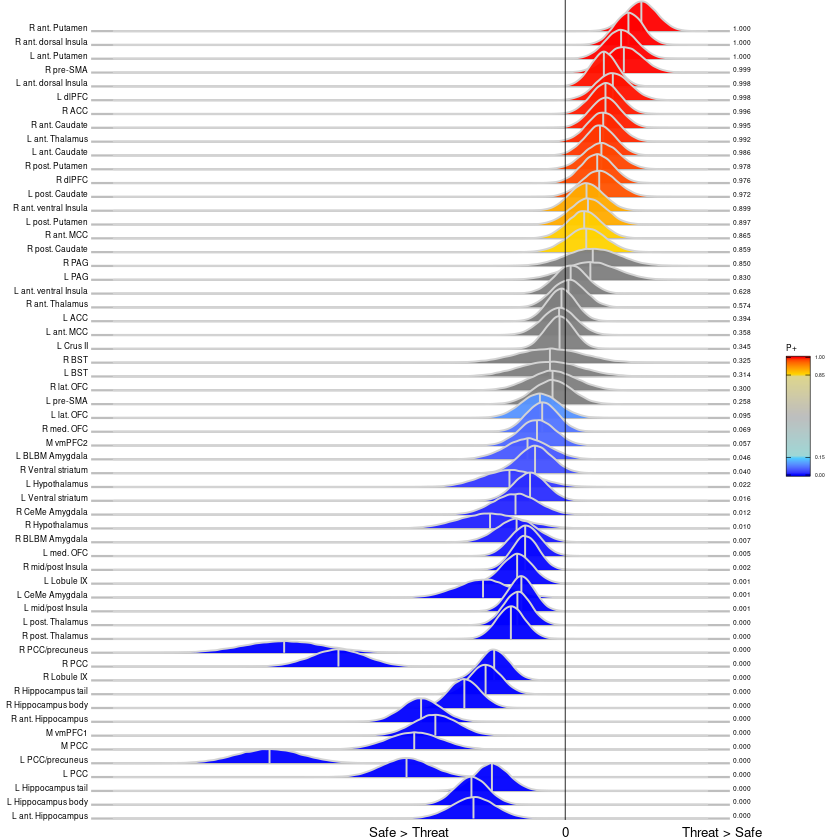

In [10]:
# Displaying posteriors only for Threat > Safe contrast (cond)
posteriors <- psROI(aa, bb, 'cond')
plotPDP(posteriors)

In [11]:
# generates ridge plots for effects (Intercept, cond, TRAIT and STATE), and saves them.
for (ii in 1:length(EOIq)){
    posteriors <- psROI(aa, bb, EOIq[ii])
    plotPDP(posteriors)
    ggsave(paste0(outDir,EOIq[ii],'.png'), width=4, height=4.5, units = "in", dpi = 900)
}

No id variables; using all as measure variables

Picking joint bandwidth of 0.00123

No id variables; using all as measure variables

Picking joint bandwidth of 0.0022

No id variables; using all as measure variables

Picking joint bandwidth of 0.00119

No id variables; using all as measure variables

Picking joint bandwidth of 0.00126



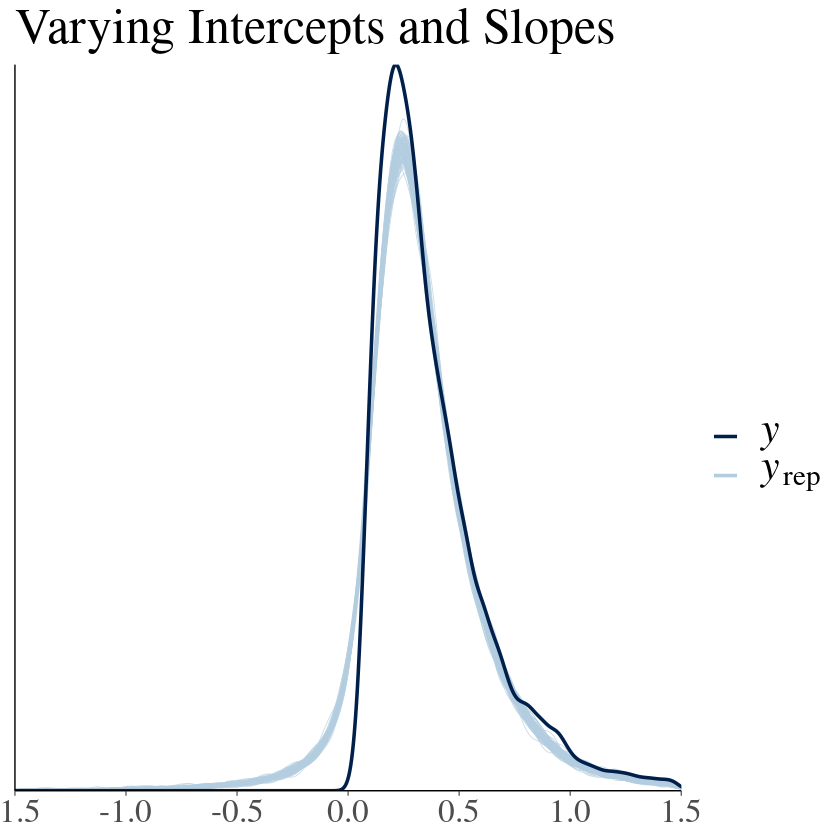

In [12]:
# Posterior predictive check
pp_plot = pp_check(fm,nsamples = 100)
pp_plot + xlim(-1.5,1.5) + theme(text = element_text(size=25),legend.text=element_text(size=25)) + ggtitle("Varying Intercepts and Slopes",)